In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import os.path

In [3]:
scenarios_folder = os.path.expanduser('~/interscsimulator/scenarios/digital-rails-sp/')
dr_events_filename_template = scenarios_folder + '{}/arrivals.xml'

In [4]:
def parse_arrivals(filename, prefix=''):
    tree = ET.parse(filename)
    root = tree.getroot()

    events = []
    for child in root:        
        if (len(prefix) == 0 or (prefix in child.attrib['person'])):
            name = child.attrib['person']
            trip_time = int(child.attrib['trip_time'])
            distance = int(child.attrib['distance'])

            events.append({
                'trip_time_s': trip_time, 
                'distance_m': distance,
                'name': name
            })

    return pd.DataFrame(events)

In [5]:
scenarios = [
    ('trace_0lanes_0pc',     0, 0),
    ('trace_1lane_0pc',      0, 1),
    ('trace_1lane_25pc',  0.25, 1),
    ('trace_1lane_50pc',   0.5, 1),
    ('trace_1lane_75pc',  0.75, 1),
    ('trace_1lane_100pc',  1.0, 1)
]

dfs = []
for filename, ratio, dr_lanes in scenarios:
    df = parse_arrivals(dr_events_filename_template.format(filename))
    df['speed'] = 3.6 * (df['distance_m'] / df['trip_time_s'])
    df['ratio'] = ratio
    df['dr_lanes'] = dr_lanes
    df['digital_rails'] = df['name'].apply(lambda name: name.startswith('dr_'))
    dfs.append(df)
    
df = pd.concat(dfs)
df.tail()

distance_m           name  trip_time_s      speed  ratio  dr_lanes  \
417960        6980  dr_5676_203_1         1496  16.796791    1.0         1   
417961        1238    dr_9163_7_1          101  44.126733    1.0         1   
417962        6980   dr_5676_36_1         1463  17.175666    1.0         1   
417963        4005    dr_5718_4_1          464  31.073276    1.0         1   
417964       11587    dr_3132_9_1          938  44.470362    1.0         1   

        digital_rails  
417960           True  
417961           True  
417962           True  
417963           True  
417964           True

In [6]:
trip_categories = 4
pd.qcut(df['distance_m'], trip_categories).unique()

[(29.999, 3677.0], (3677.0, 6545.0], (6545.0, 11162.0], (11162.0, 33201.0]]
Categories (4, interval[float64]): [(29.999, 3677.0] < (3677.0, 6545.0] < (6545.0, 11162.0] < (11162.0, 33201.0]]

In [7]:
df['trip_category'] = pd.qcut(df['distance_m'], trip_categories)

In [8]:
aggs = {'distance_m': ['mean', 'std'], 'trip_time_s': ['mean', 'std'], 'speed': ['mean', 'std']}
gdf = df.groupby(['ratio', 'dr_lanes', 'trip_category']).agg(aggs).sort_index()
gdf

distance_m               trip_time_s  \
                                           mean          std         mean   
ratio dr_lanes trip_category                                                
0.00  0        (29.999, 3677.0]     1805.140301   977.897195   356.797030   
               (3677.0, 6545.0]     5192.249443   825.447023  1078.655196   
               (6545.0, 11162.0]    8612.979143  1317.603254  1759.816634   
               (11162.0, 33201.0]  15549.975191  3488.426874  2052.363401   
      1        (29.999, 3677.0]     1805.131402   977.874534   419.906106   
               (3677.0, 6545.0]     5191.949765   825.583884  1254.952695   
               (6545.0, 11162.0]    8613.645267  1317.454479  1901.596780   
               (11162.0, 33201.0]  15550.095452  3488.518904  2204.174571   
0.25  1        (29.999, 3677.0]     1805.032957   977.853510   315.369002   
               (3677.0, 6545.0]     5192.101982   825.517570  1007.484837   
               (6545.0, 11162.0]    8612.895479  1317.558788  1562.276169   
               (11162.0, 33201.0]  15549.919746  3488.198660  1855.348277   
0.50  1        (29.999, 3677.0]     1805.021078   977.850652   270.218848   
               (3677.0, 6545.0]     5192.164641   825.505369   829.844812   
               (6545.0, 11162.0]    8612.277465  1317.694260  1288.442787   
               (11162.0, 33201.0]  15550.552275  3488.294014  1616.689735   
0.75  1        (29.999, 3677.0]     1805.021078   977.850652   246.446109   
               (3677.0, 6545.0]     5192.205096   825.500359   723.375413   
               (6545.0, 11162.0]    8611.616419  1317.840516  1113.146829   
               (11162.0, 33201.0]  15550.479065  3488.201538  1474.857588   
1.00  1        (29.999, 3677.0]     1805.021078   977.850652   240.973562   
               (3677.0, 6545.0]     5192.305355   825.471351   675.015220   
               (6545.0, 11162.0]    8611.217301  1317.926768  1066.872153   
               (11162.0, 33201.0]  15550.523891  3488.220007  1428.408146   

                                                    speed             
                                           std       mean        std  
ratio dr_lanes trip_category                                          
0.00  0        (29.999, 3677.0]     387.878943  31.753579  23.882401  
               (3677.0, 6545.0]     747.265078  23.766665  12.287933  
               (6545.0, 11162.0]   1048.660511  22.863214  10.994681  
               (11162.0, 33201.0]   927.477058  31.374289  11.678861  
      1        (29.999, 3677.0]     429.895847  24.640212  17.936634  
               (3677.0, 6545.0]     900.096566  21.774140  12.434764  
               (6545.0, 11162.0]   1106.697490  21.468710  10.867074  
               (11162.0, 33201.0]  1063.768507  29.784689  11.527660  
0.25  1        (29.999, 3677.0]     322.472461  32.745170  23.232966  
               (3677.0, 6545.0]     694.983882  25.225350  12.365348  
               (6545.0, 11162.0]    862.780100  24.868204  11.022004  
               (11162.0, 33201.0]   785.231848  33.850419  11.370615  
0.50  1        (29.999, 3677.0]     240.595555  34.002247  22.564327  
               (3677.0, 6545.0]     485.414064  27.699662  11.455343  
               (6545.0, 11162.0]    592.054702  27.967386  10.190261  
               (11162.0, 33201.0]   539.425606  36.962759  10.183521  
0.75  1        (29.999, 3677.0]     188.380163  34.742729  22.170826  
               (3677.0, 6545.0]     335.593966  29.441356  10.329484  
               (6545.0, 11162.0]    391.387607  30.517702   9.148381  
               (11162.0, 33201.0]   400.210308  39.443826   9.057541  
1.00  1        (29.999, 3677.0]     171.876586  34.881432  22.146102  
               (3677.0, 6545.0]     215.709860  30.119066   9.547856  
               (6545.0, 11162.0]    322.185470  31.242582   8.760758  
               (11162.0, 33201.0]   351.990313  40.417745   8.759955

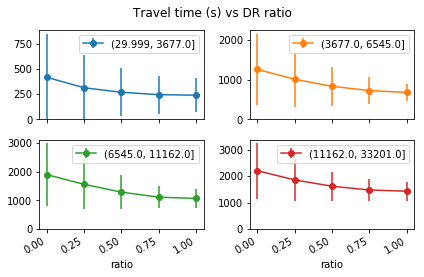

In [9]:
gdf0 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 0]
gdf1 = gdf.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 1]

benchs = gdf0['trip_time_s']['mean'].unstack('trip_category')
travel_times =  gdf1['trip_time_s']['mean'].unstack('trip_category')



ax = travel_times.plot(
    yerr=gdf1['trip_time_s']['std'].unstack('trip_category'),
    ylim=(0, None),
    marker='o', 
    title='Travel time (s) vs DR ratio',
    subplots=True,
    layout=(2,2)
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

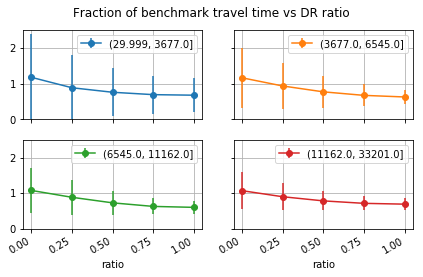

In [10]:
ax = (travel_times / benchs.iloc[0]).plot(
    yerr=(gdf1['trip_time_s']['std'].unstack('trip_category') / benchs.iloc[0]),
    ylim=(0, None),
    marker='o', 
    title='Fraction of benchmark travel time vs DR ratio',
    subplots=True,
    layout=(2,2),
    sharey=True,
    grid=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Average speed  ##

In [11]:
# ax = gdf1['speed']['mean']\
#     .unstack('trip_category').plot(
# #         yerr=gdf1['speed']['std'].unstack('trip_category'),
#         ylim=(0, None),
#         marker='o', 
#         title='Speed (km/h) vs DR ratio',
#         subplots=True,
#         layout=(2,2),
#         sharey=True
#     )

# print(gdf0['speed']['mean'].tolist())

# benchs = gdf0['speed']['mean'].tolist()
# i = 0
# for a in ax:
#     for axis in a:
#         axis.hlines(benchs[i], xmin=0, xmax=1)
#         i += 1
# #         axis.hlines(y=[bdf['trip_time_s'].mean()+bdf['trip_time_s'].std(), bdf['trip_time_s'].mean()-bdf['trip_time_s'].std()], xmin=0, xmax=1, linestyle='--')

In [12]:
aggs2 = {'distance_m': ['mean', 'std'], 'trip_time_s': ['mean', 'std'], 'speed': ['mean', 'std']}
gdf2 = df.groupby(['ratio', 'dr_lanes', 'trip_category', 'digital_rails']).agg(aggs).sort_index()

gdf02 = gdf2.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 0]
gdf12 = gdf2.reset_index('dr_lanes').loc[lambda df: df.dr_lanes == 1]

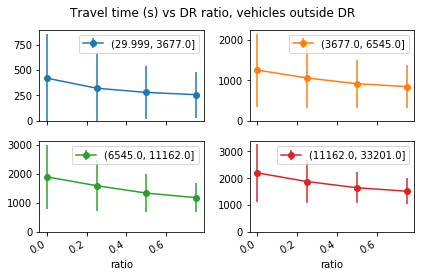

In [13]:
benchs = gdf0['trip_time_s']['mean'].unstack('trip_category')
travel_times_out = gdf12.reset_index('digital_rails').loc[lambda df: df.digital_rails == False]['trip_time_s']['mean'].unstack('trip_category')
travel_times_out_std = gdf12.reset_index('digital_rails').loc[lambda df: df.digital_rails == False]['trip_time_s']['std'].unstack('trip_category')

ax = travel_times_out.plot(
    yerr=travel_times_out_std,
    ylim=(0, None),
    marker='o', 
    title='Travel time (s) vs DR ratio, vehicles outside DR',
    subplots=True,
    layout=(2,2),
#     sharey=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

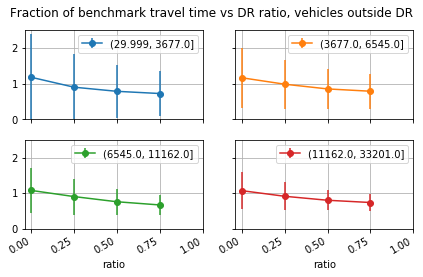

In [14]:
ax = (travel_times_out / benchs.iloc[0]).plot(
    yerr=(travel_times_out_std / benchs.iloc[0]),
    ylim=(0, None),
    marker='o', 
    title='Fraction of benchmark travel time vs DR ratio, vehicles outside DR',
    subplots=True,
    layout=(2,2),
    sharey=True,
    grid=True,
    xticks=[0, .25, .5, .75, 1.0]
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
travel_times / benchs.iloc[0]

trip_category  (29.999, 3677.0]  (3677.0, 6545.0]  (6545.0, 11162.0]  \
ratio                                                                  
0.00                   1.176877          1.163442           1.080565   
0.25                   0.883889          0.934019           0.887749   
0.50                   0.757346          0.769333           0.732146   
0.75                   0.690718          0.670627           0.632536   
1.00                   0.675380          0.625793           0.606241   

trip_category  (11162.0, 33201.0]  
ratio                              
0.00                     1.073969  
0.25                     0.904006  
0.50                     0.787721  
0.75                     0.718614  
1.00                     0.695982

In [16]:
travel_times_out / benchs.iloc[0]

trip_category  (29.999, 3677.0]  (3677.0, 6545.0]  (6545.0, 11162.0]  \
ratio                                                                  
0.00                   1.176877          1.163442           1.080565   
0.25                   0.899683          0.983278           0.908006   
0.50                   0.784178          0.851458           0.763246   
0.75                   0.722306          0.786786           0.673717   

trip_category  (11162.0, 33201.0]  
ratio                              
0.00                     1.073969  
0.25                     0.916516  
0.50                     0.805152  
0.75                     0.742277